In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binomtest

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def confidence_interval(successes, trials=100):
    ci = binomtest(successes, trials).proportion_ci(confidence_level=0.95, method="wilson")
    return ci.low, ci.high

In [3]:
def mcts_compute_pass_at_t_and_ci(df, t):
    passes = (df[f"final/n_tokens"] <= t).sum()
    total = len(df)
    pass_at_t = passes / total
    low, high = confidence_interval(passes, total)
    return pass_at_t, low, high

def whole_compute_pass_at_t_and_ci(df, t):
    passes = []
    token_counter = 0
    for row in df.iterrows():
        token_counter += row[1]["n_tokens"]
        if row[1]["is_solution"]:
            passes.append(1)
            token_counter = 0
        elif token_counter > t:
            passes.append(0)
            token_counter = 0

    total_passes = np.sum(passes)
    total_trials = len(passes)
    pass_at_t = total_passes / total_trials
    low, high = confidence_interval(total_passes, total_trials)
    return pass_at_t, low, high

In [4]:
whole_df = pd.read_csv("best_whole_evalopt0.csv")
vmcts_df = pd.read_csv("best_vmcts_evalopt0.csv")
reflexion_df = pd.read_csv("best_reflexion_evalopt0.csv")

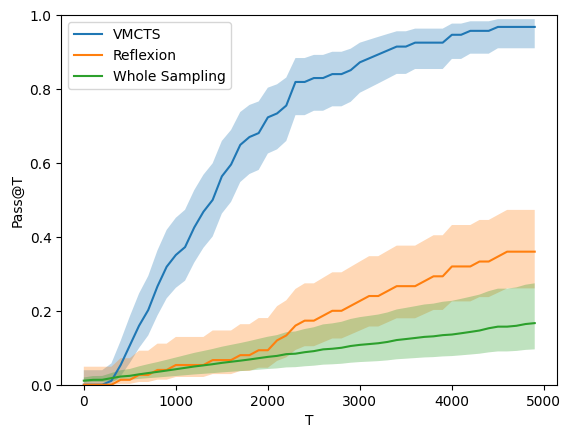

In [8]:
ts = np.arange(0, 5000, 100)

def plot_df(df, label, whole = False):
    success_rates, lows, highs = [], [], []
    for t in ts:
        if whole:
            success_rate, low, high = whole_compute_pass_at_t_and_ci(df, t)
        else:
            success_rate, low, high = mcts_compute_pass_at_t_and_ci(df, t)
        success_rates.append(success_rate)
        lows.append(low)
        highs.append(high)

    plt.plot(ts, success_rates, label=label)
    plt.fill_between(ts, lows, highs, alpha=0.3)

plot_df(vmcts_df, "VMCTS")
plot_df(reflexion_df, "Reflexion")
plot_df(whole_df, "Whole Sampling", whole=True)


plt.legend(loc="upper left") #, bbox_to_anchor=(1,1))
plt.xlabel("T")
plt.ylabel("Pass@T")
#plt.title("Pass@T vs. T")
plt.ylim(0,1)
plt.show()